# pyfox example


In [1]:
# This cell makes html renders of the notebook have hidden code cells.
# Especially useful for presentations. It does nothing within the
# jupyter lab environment.
from IPython.display import HTML

hide_me = ''
HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

In [2]:
# netcdf/numpy/xray/stats
import numpy as np
import xarray as xr
import yaml

# OS interaction
import os

# import plotting
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import string
import datetime
import pandas as pd
import copy
import btmm_process

# Often there are annoying "divide by zero" warning messages. They are not useful so we ignore them.
import warnings
warnings.filterwarnings("ignore")

## Format plots

In [3]:
%matplotlib inline
# Higher resolution figures within the notebook
# %config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.dpi']= 200

# Set the plot style from the seaborn library
sns.set_style("whitegrid")
context = 'paper'
sns.set_context("paper", rc={"font.size":8,"axes.titlesize":8,"axes.labelsize":8})

# Define a default color palette (this should be fairly color blind friendly)
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
sns.set_palette(sns.color_palette(flatui))

# Define a line style list
ls_list = ['-', '--', ':', '-']
ms_list = ['v', '*', 's', 'o']

alphabet = list(string.ascii_lowercase)

### Directories

- The example notebook assumes that the directory structure is identical to the one found on github.

In [4]:
# DTS data
dir_dts_data = os.getcwd()
dir_data_cal = os.path.join(dir_dts_data, 'calibrated')
dir_data_raw = os.path.join(dir_dts_data,  'raw_netcdf')
dir_data_final = os.path.join(dir_dts_data, 'final')

# Met data
dir_ref_data = os.path.join(dir_dts_data, 'reference_temperature')

#### Load the configuration file

We need to refer to the location library later for mapping the reference sections and evaluating the calibration.

In [5]:
os.chdir(dir_dts_data)

# Read location library
# cfg = os.path.join(dir_dts_data, 'example_configuration.yml')
cfg = '/Users/karllapo/Desktop/KL_localver_example_configuration.yml'
cfg = yaml.load(cfg)
with open(cfg, 'r') as stream:
    cfg = yaml.load(stream)

# For ease of reference the location library is stored in its own dictionary.
phys_locs = cfg['location_library']
# Extract out the reference baths from the mapping library.
#Reference baths MUST be labeled with `calibration` as the `loc_type`.
bath_names = [pl for pl in phys_locs
              if phys_locs[pl]['loc_type'] == 'calibration']

# This is a multicore fiber. We list the core names here for examining them later.
cores = ['p1', 'p2', 'ss']
core_locs = cfg['dataProperties']['cores']
print(core_locs)

{'p1': {'LAF': [0, 655]}, 'p2': {'LAF': [655, 1305]}, 'ss': {'LAF': [1305, 2695]}}


# Raw data

This step can be run after converting the archived data into `raw_netcdfs`, e.g. within the pyfox config file

```python
archive_read_flag = True
```

For the example this step of pyfox has already been completed for saving space. Instead we provide a sample of a white pvc fiber optic cable in a rectangular configuration for a five minute interval at midnight. This fiber was observed as part of a set of nested fibers. It passes through 2 reference sections, cooled and heated blocks of copper, at both the very beginning and end of the fiber optic array. These reference section copper blocks give two known temperatures at four points. They were monitored using embedded pt100s. These temperatures and reference sections allow the single-ended calibration for the FODS array.

### Data check - file contents

First, let us see what is included in the netcdfs without any processing. The original data files in the archive contain DTS data from fibers arrayed in nested rectangles around a grass field. As this includes several different cores that complicate data analysis, we instead select just the first fiber which is found between `LAF = (0m, 655m)`. We will use this data for the rest of the notebook. 

In [6]:
os.chdir(dir_data_raw)
ds = xr.open_dataset('raw_channel 1_20190722-0000.nc')

print(ds)

<xarray.Dataset>
Dimensions:  (LAF: 11498, time: 57)
Coordinates:
  * LAF      (LAF) float64 -222.9 -222.6 -222.4 ... 2.699e+03 2.699e+03 2.7e+03
  * time     (time) datetime64[ns] 2019-07-22T00:00:03 ... 2019-07-22T00:04:59
Data variables:
    Ps       (time, LAF) float64 ...
    Pas      (time, LAF) float64 ...
    temp     (time, LAF) float64 ...
Attributes:
    LAF_beg:  -222.866
    LAF_end:  2699.663
    dLAF:     0.254


The netcdf contains the stokes and anti-stokes intensities (`Ps` and `Pas`) and the instrument reported temperature (`temp`). All three data variables are matrices with dimensions labeled by length along fiber (`LAF`) and time (`time`). Other attributes, such as the total fiber length and the spatial resolution are stored as well. The xarray dataset is the container that we use for all further operations in pyfox.

### Data check - instrument reported temperatures

After this step the data quality and mapping needs to be checked. First we look at the instrument reported temperature, stored within the `temp` field in the netcdf.

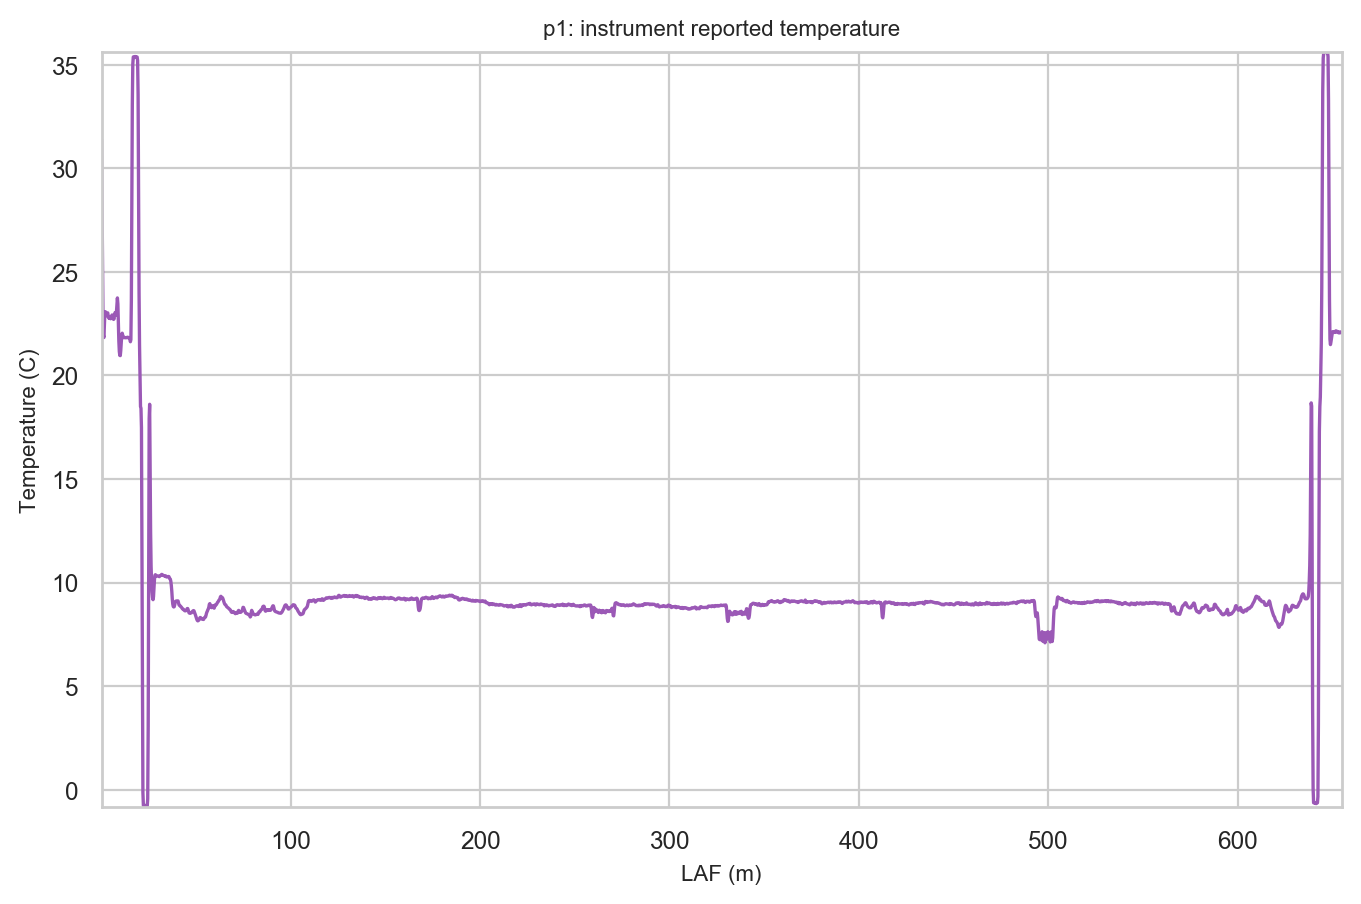

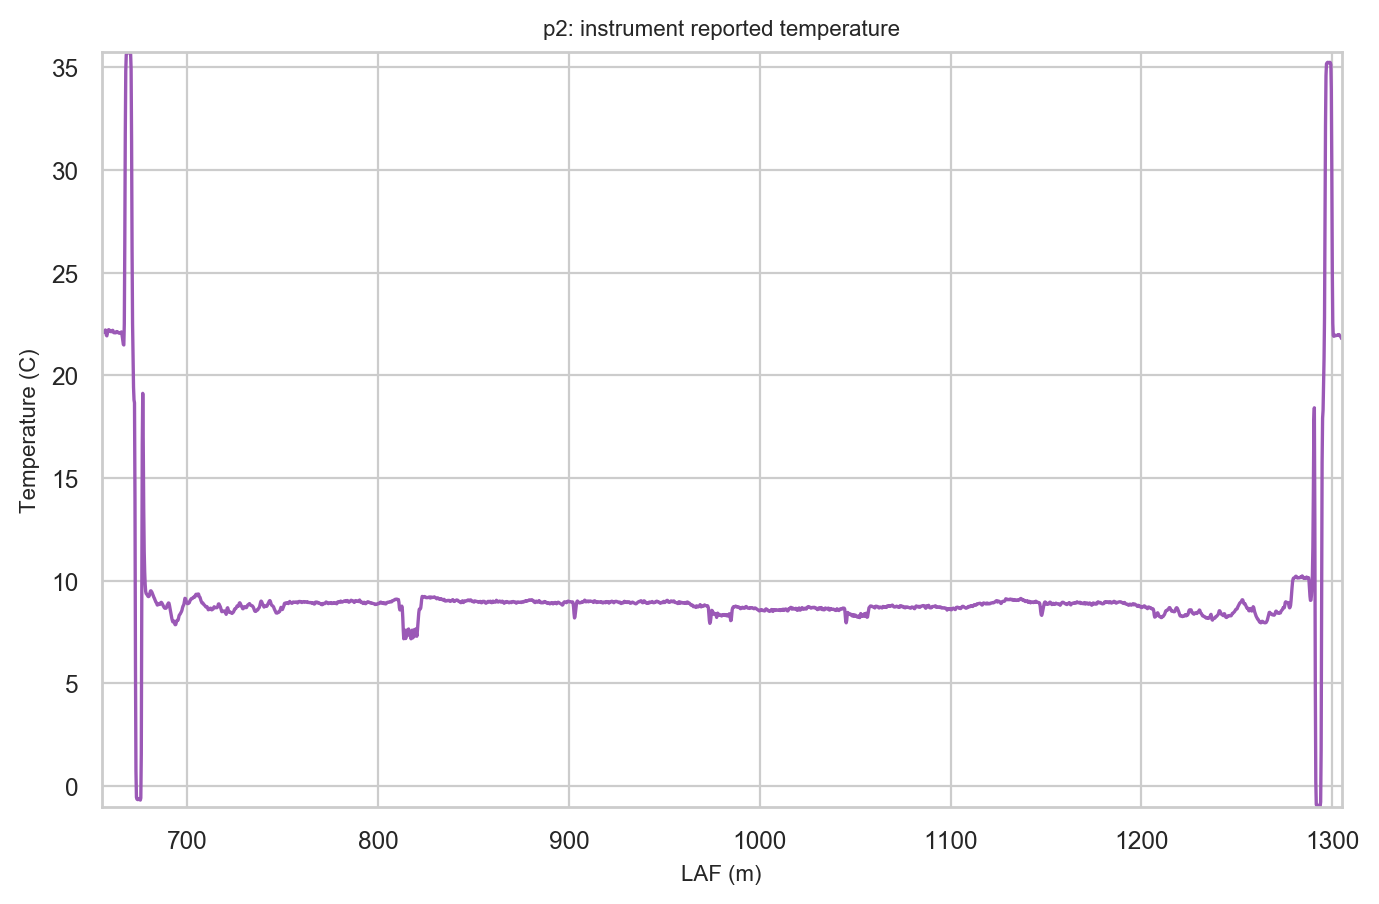

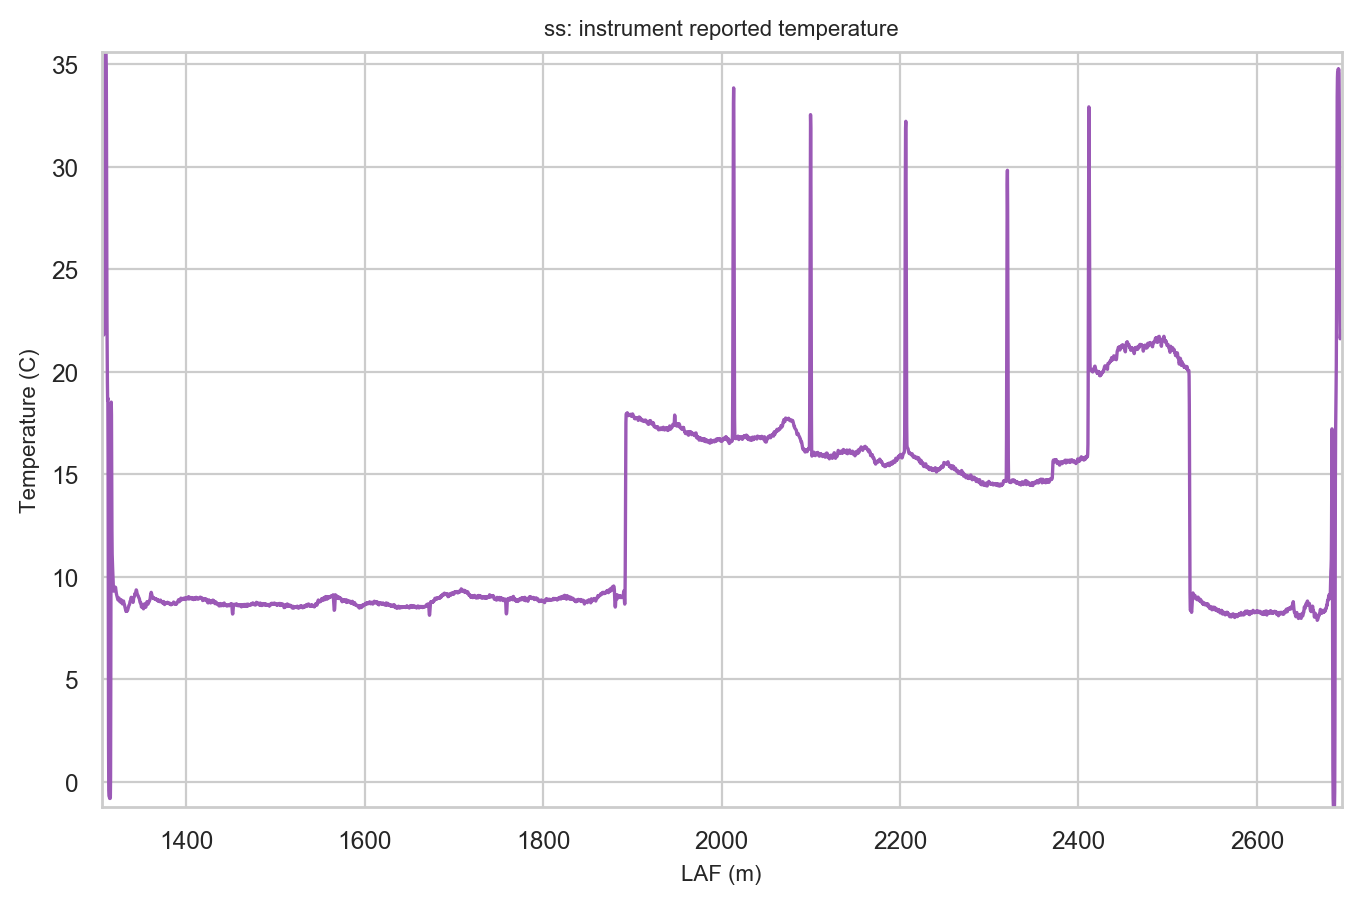

In [7]:
# Loop over every core in the configuration. Reference baths
for c in cores:
    c_LAF_start = core_locs[c]['LAF'][0]
    c_LAF_end = core_locs[c]['LAF'][1]
    
    # Select just the first twisted pair.
    smpl_data = ds.sel(LAF=slice(c_LAF_start, c_LAF_end))

    # Time average the data
    smpl_data_mean = smpl_data.mean(dim='time')

    # Let's look at the entire fiber
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(smpl_data_mean.LAF,
            smpl_data_mean.temp)

    ax.set_xlim(c_LAF_start, c_LAF_end)

    ax.autoscale(enable=True, tight=True)
    ax.set_ylabel('Temperature (C)')
    ax.set_xlabel('LAF (m)')
    ax.set_title(c + ': instrument reported temperature')

Second, we look at the reference sections, specifically making sure our boundaries for the reference section make sense and that the baths are well-behaved (flat in power anomaly and instrument reported temperature). The power anomaly within the reference sections is the best test for both of these issues. Within the reference sections the power anomaly should be flat and very near to zero.

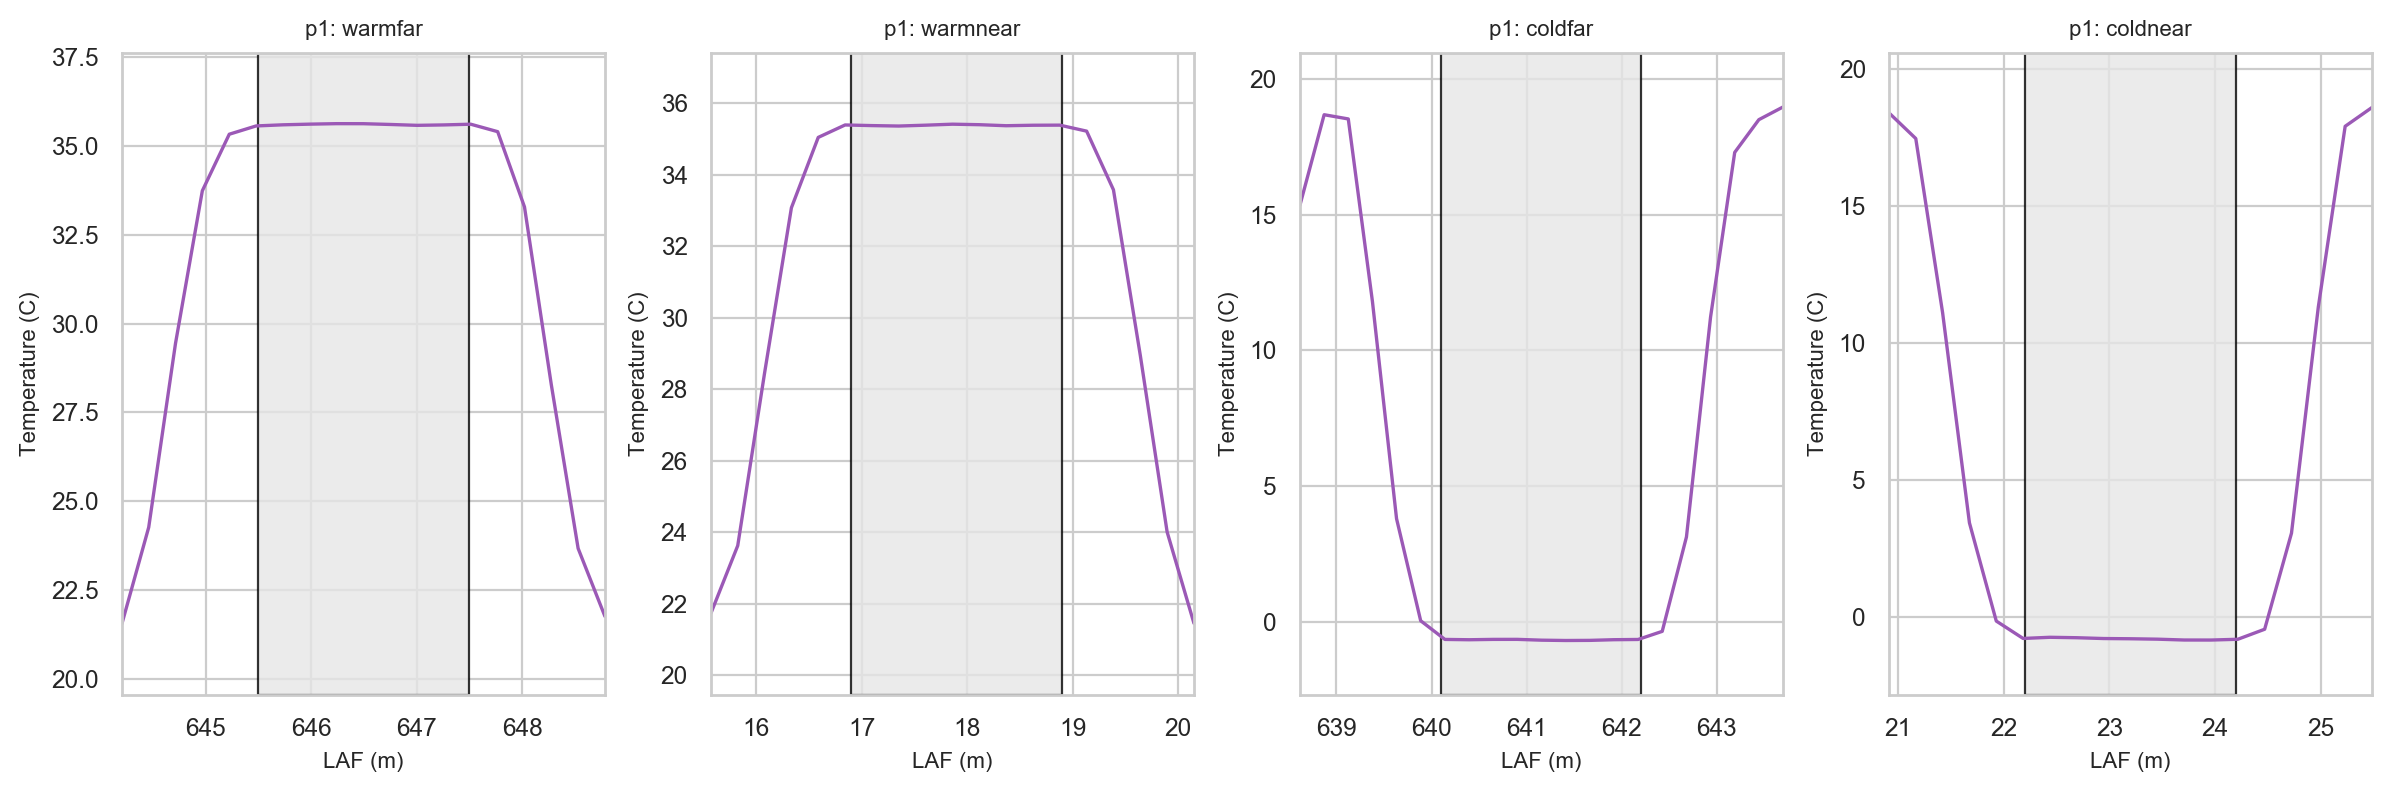

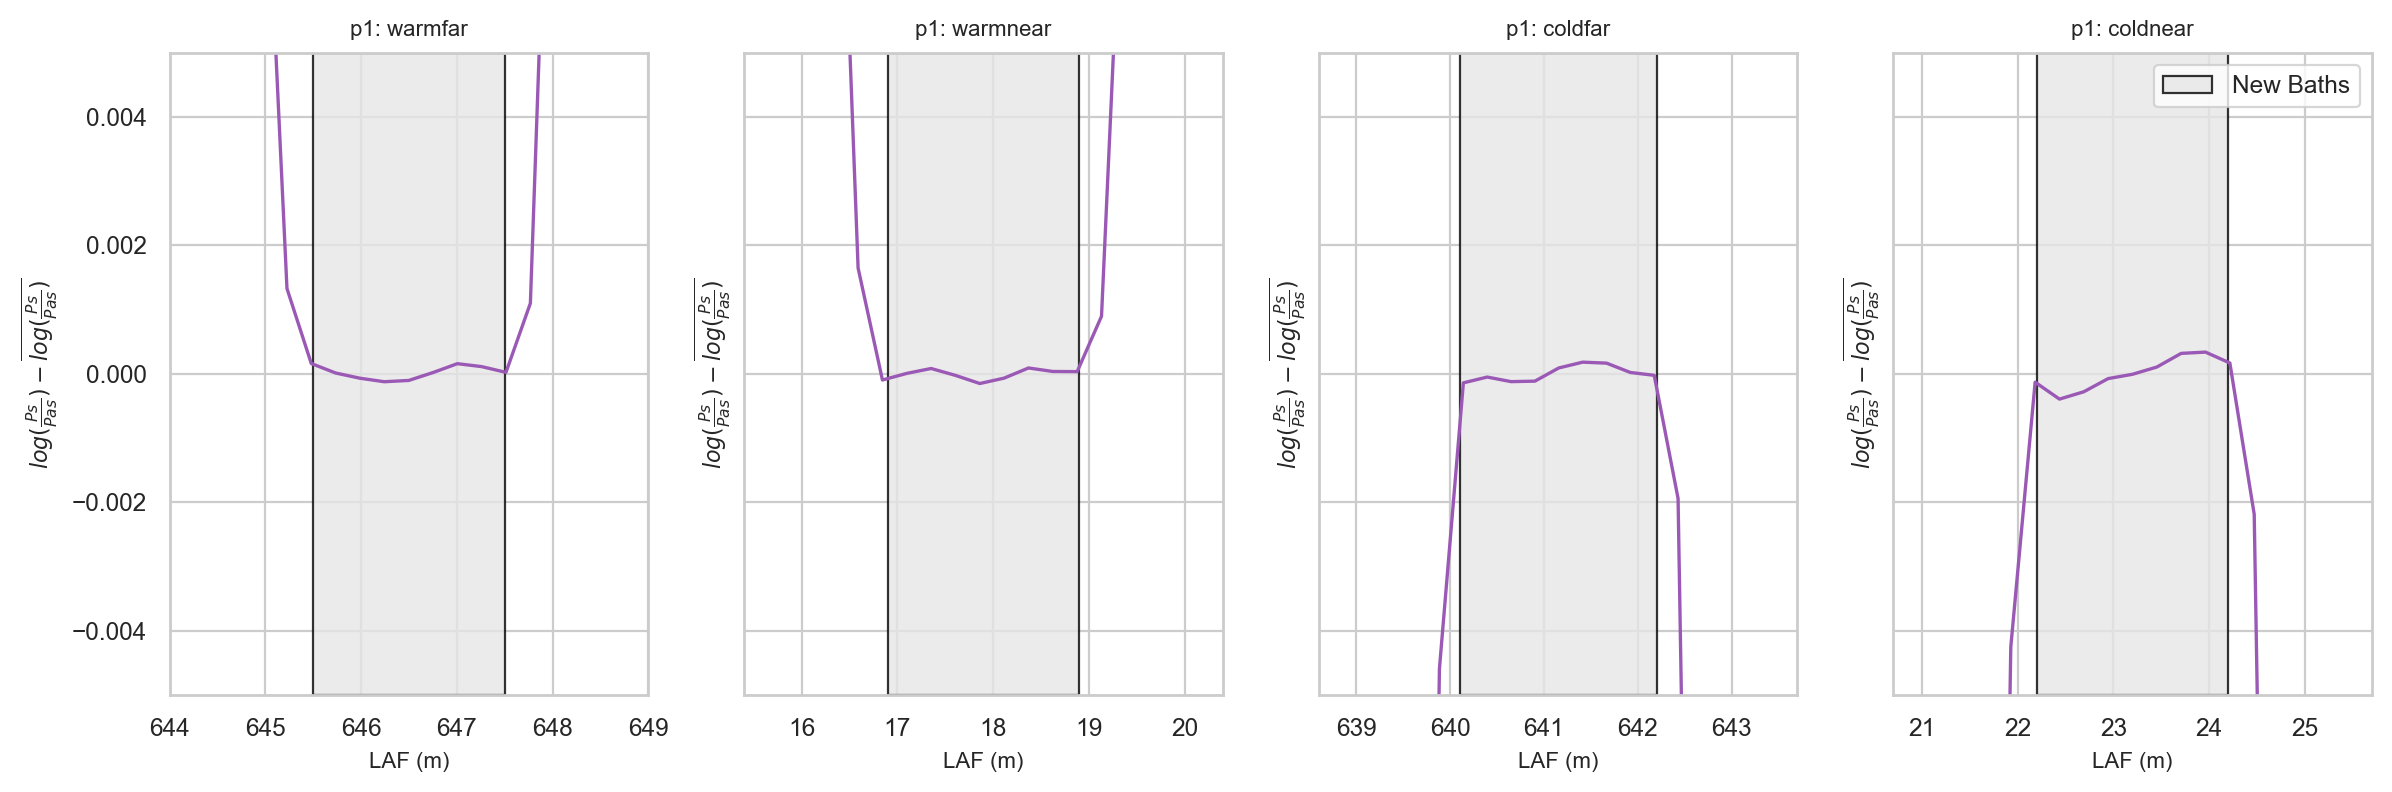

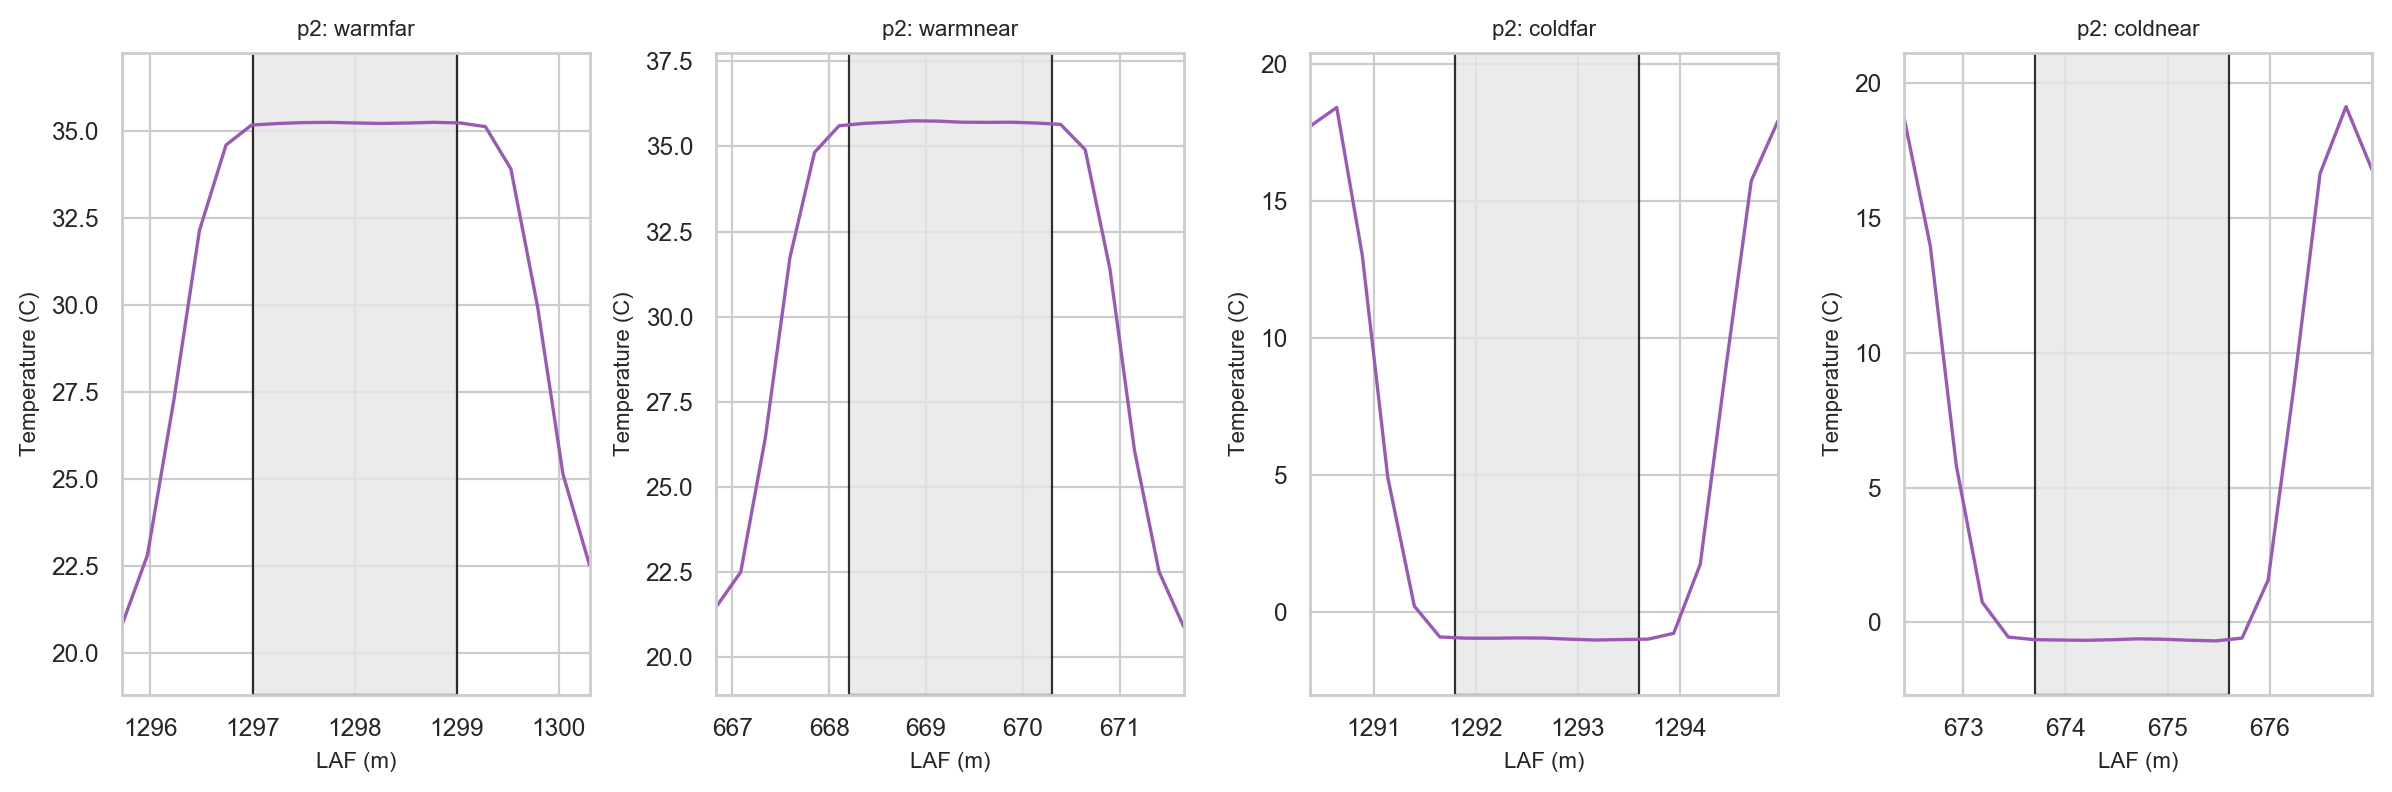

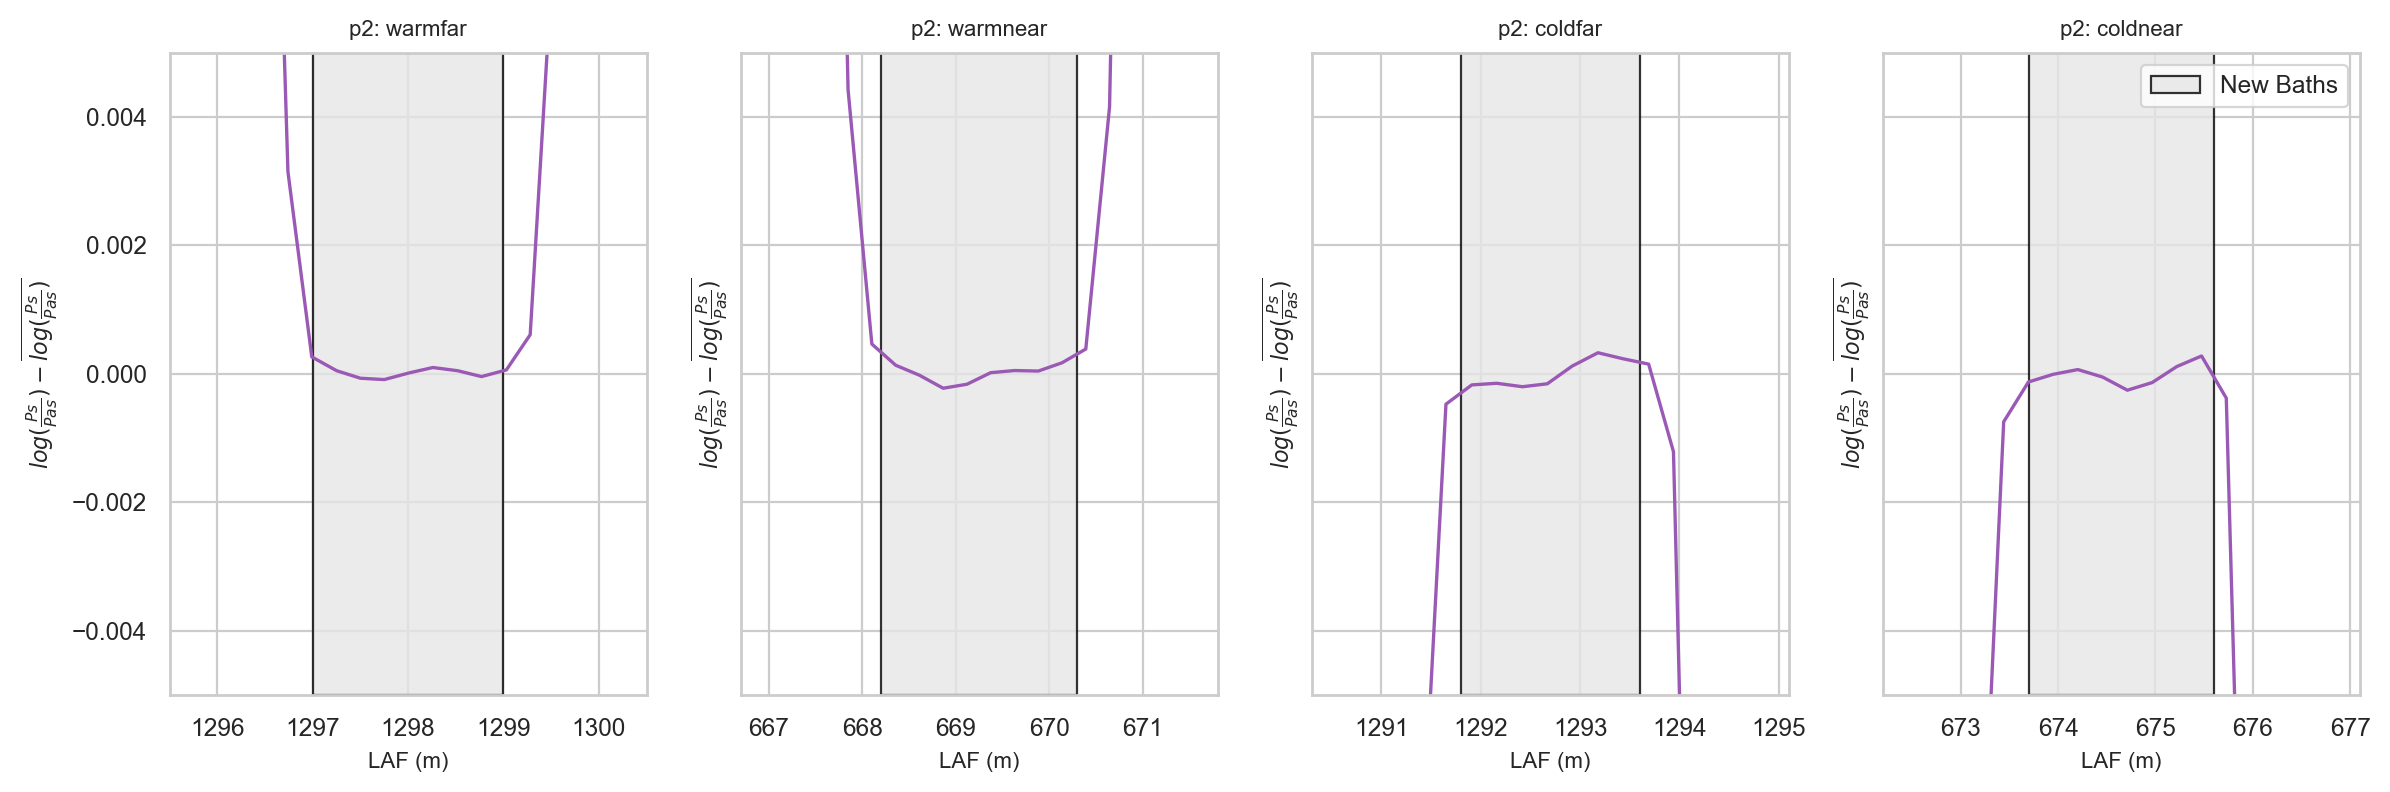

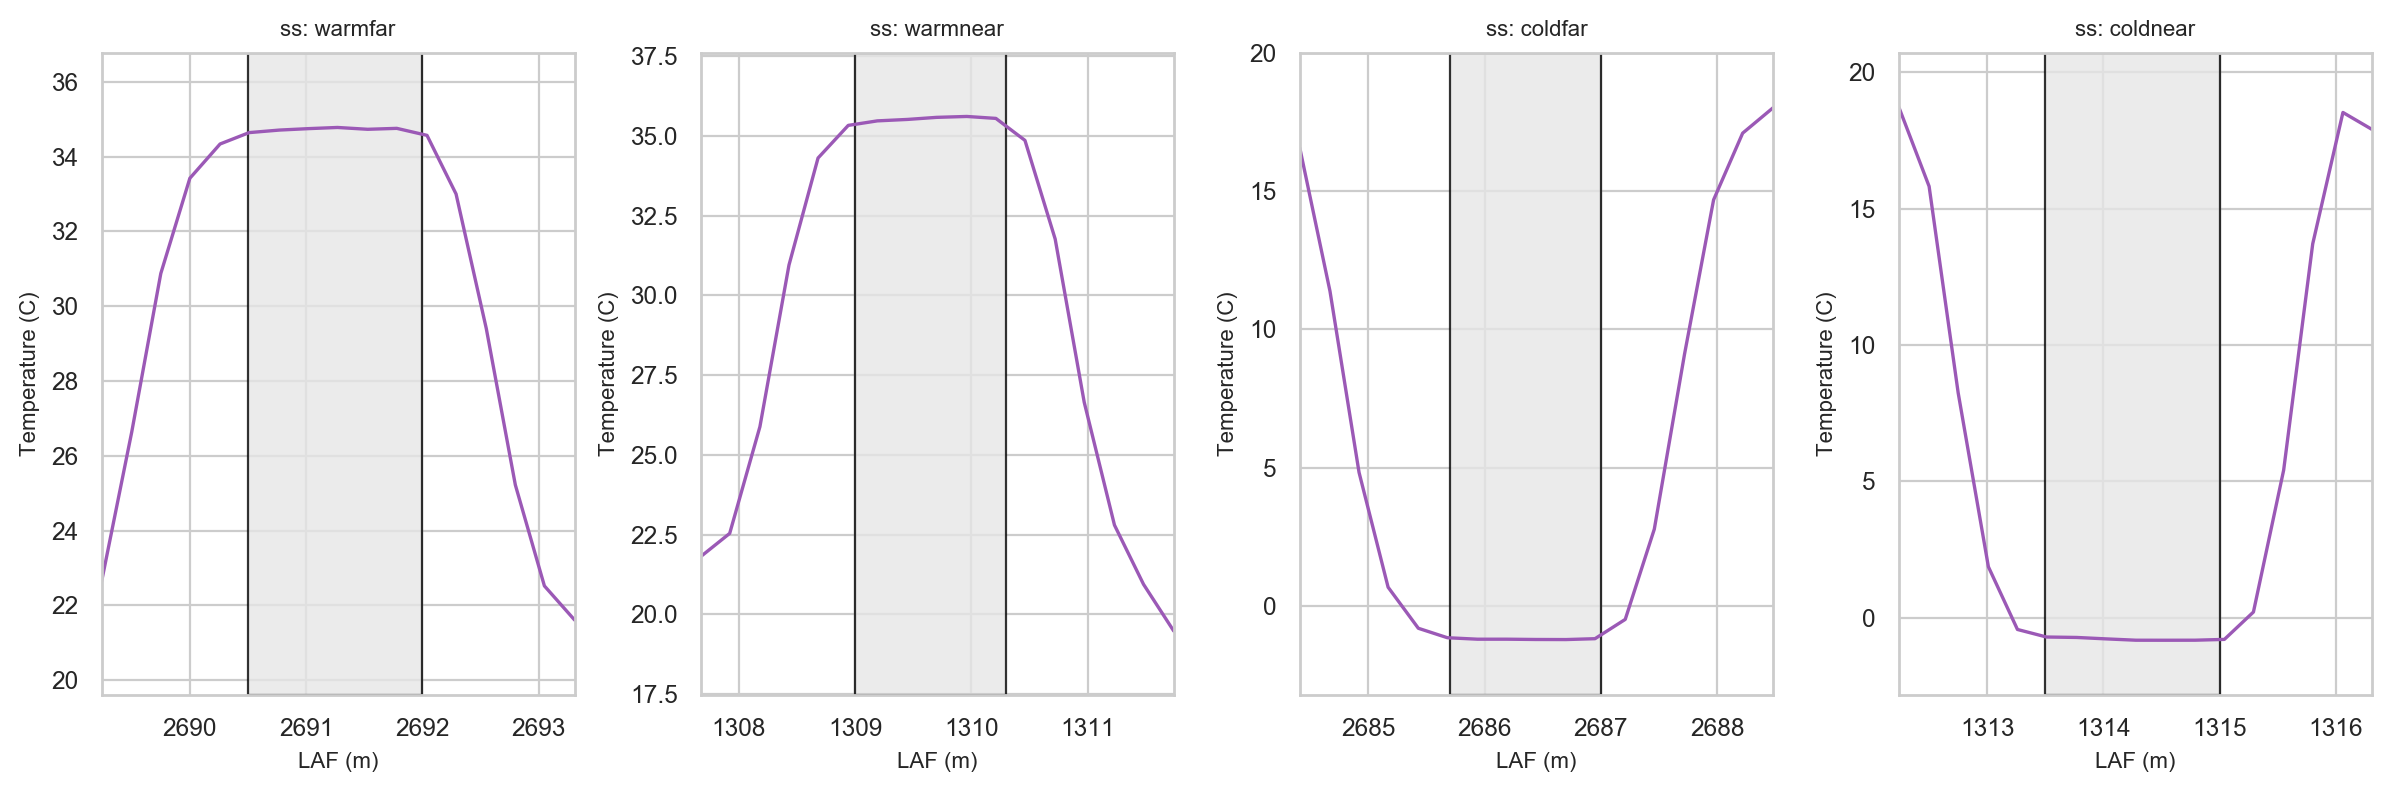

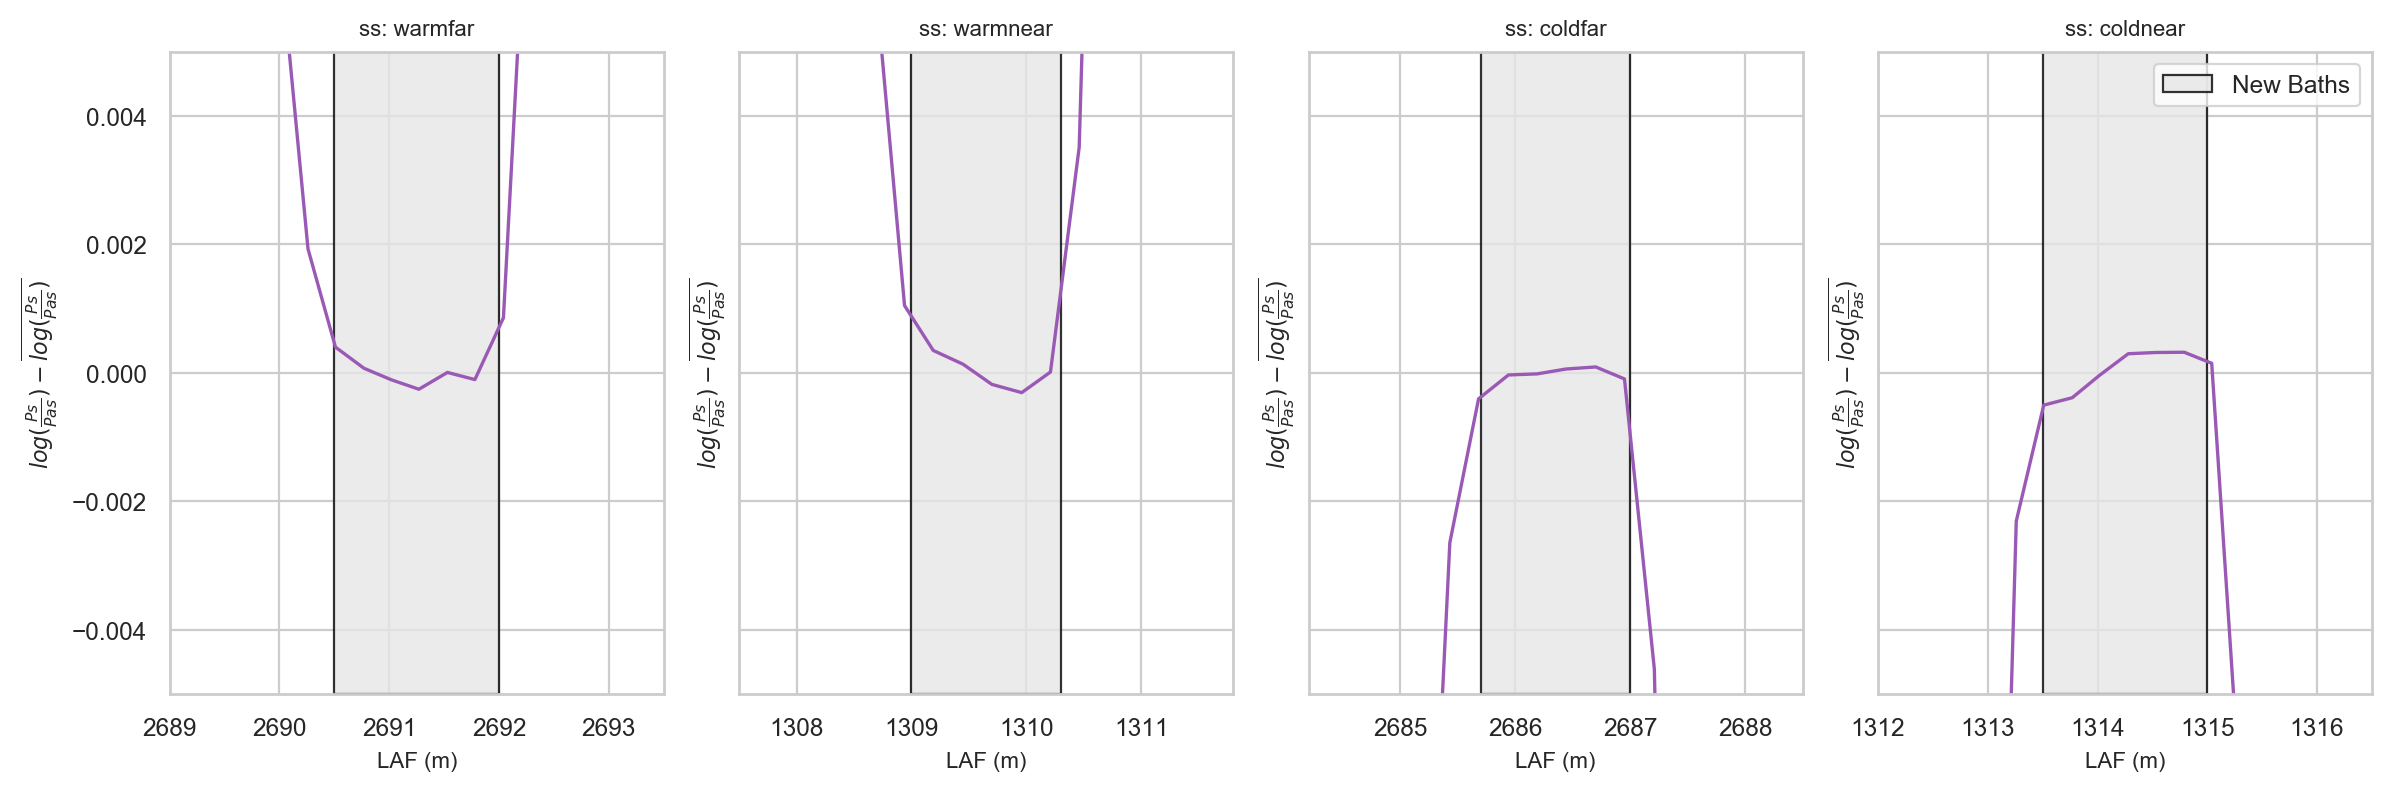

In [8]:
# Loop over every core in the configuration. Reference baths
for c in cores:
    c_LAF_start = core_locs[c]['LAF'][0]
    c_LAF_end = core_locs[c]['LAF'][1]
    
    # Select just the first twisted pair.
    smpl_data = ds.sel(LAF=slice(c_LAF_start, c_LAF_end))

    # Time average the data
    smpl_data_mean = smpl_data.mean(dim='time')
    
    fig, axes = plt.subplots(1, len(bath_names), figsize=(12, 4))
    for bn_num, bn in enumerate(bath_names):
        ax = axes[bn_num]
        ax.set_title(c + ': ' + bn)

        bath_start = phys_locs[bn]['LAF'][c][0]
        bath_end = phys_locs[bn]['LAF'][c][1]

        ds_bath = smpl_data_mean.sel(LAF=slice(bath_start - 1.5,
                                               bath_end + 1.5))

        # Fill in the "current" bath locations
        ax.fill_between([bath_start, bath_end],
                        ds_bath.temp.min() - 2, ds_bath.temp.max() + 2,
                        edgecolor='k', facecolor='0.9', alpha=0.8, label='Reference Section')

        # The instrument reported temperature data
        ax.plot(ds_bath.LAF, ds_bath.temp)

        ax.autoscale(enable=True, tight=True)
        ax.set_ylabel('Temperature (C)')
        ax.set_xlabel('LAF (m)')
    fig.tight_layout()
        
    # ------------------------
    # Mean of power
    fig, axes = plt.subplots(1, len(bath_names), figsize=(12, 4), sharey=True)
    power = np.log(smpl_data_mean.Ps / smpl_data_mean.Pas)

    for bn_num, bn in enumerate(bath_names):
        ax = axes[bn_num]
        ax.xaxis.grid(True, which='minor')
        ax.set_title(c + ': ' + bn)

        bath_start = phys_locs[bn]['LAF'][c][0]
        bath_end = phys_locs[bn]['LAF'][c][1]
        mean_power = power.sel(LAF=slice(bath_start, bath_end)).mean(dim='LAF').values

        # Fill in the "current" bath locations
        ax.fill_between([bath_start, bath_end], -0.005, 0.005, edgecolor='k', facecolor='0.9', alpha=0.8, label='New Baths')

        # Power perturbation
        ax.plot(power.LAF, power.values - mean_power)

        ax.set_xlim(bath_start - 1.5, bath_end + 1.5)
        ax.set_ylim(-0.005, 0.005)

        ax.set_ylabel(r'$log(\frac{Ps}{Pas}) - \overline{log(\frac{Ps}{Pas})}$')
        ax.set_xlabel('LAF (m)')
    ax.legend(loc='upper right', frameon=True)
    fig.tight_layout()

ax.legend()
fig.tight_layout()

There is potentially something wrong within the `coldnear` bath. The slope in the power anomaly is atypical and may be caused by some fiber artifact such as tension being applied to the fiber. The boundaries for `coldfar` could be adjusted to be slightly smaller.

The bath locations we provided to the location library include the transition between the ambient and reference section temperature. Checking the reference sections is a necessary step in order to correct these types of issues. 

### Data check - $log(\frac{P_s}{P_{as}})$

The log ratio of the stokes/anti-stokes intensities are necessary for important diagnostics of the fiber. Here we walk through several basic checks. First, we look at the mean power and the standard deviation of the power across the whole fiber.

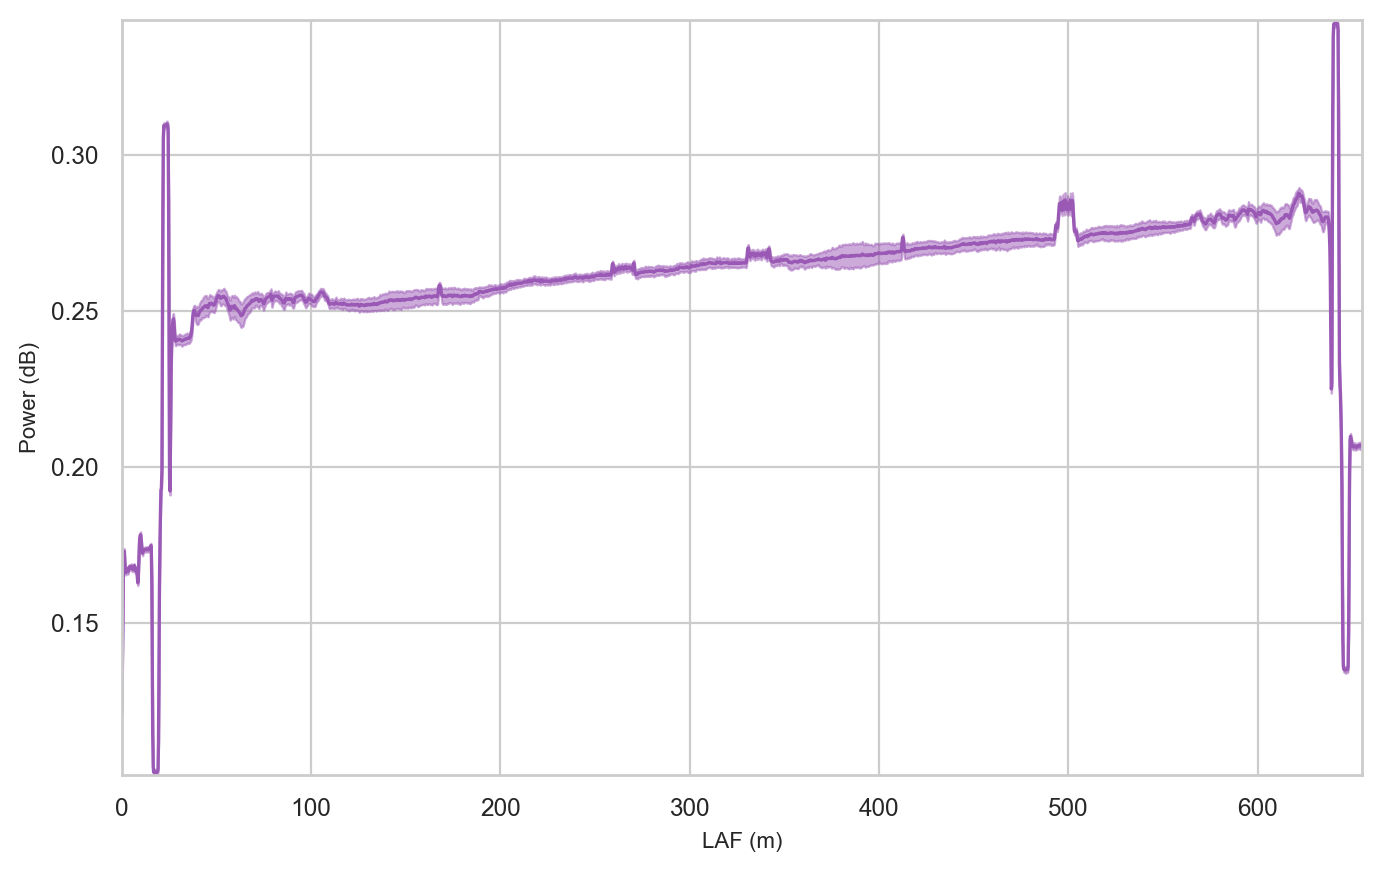

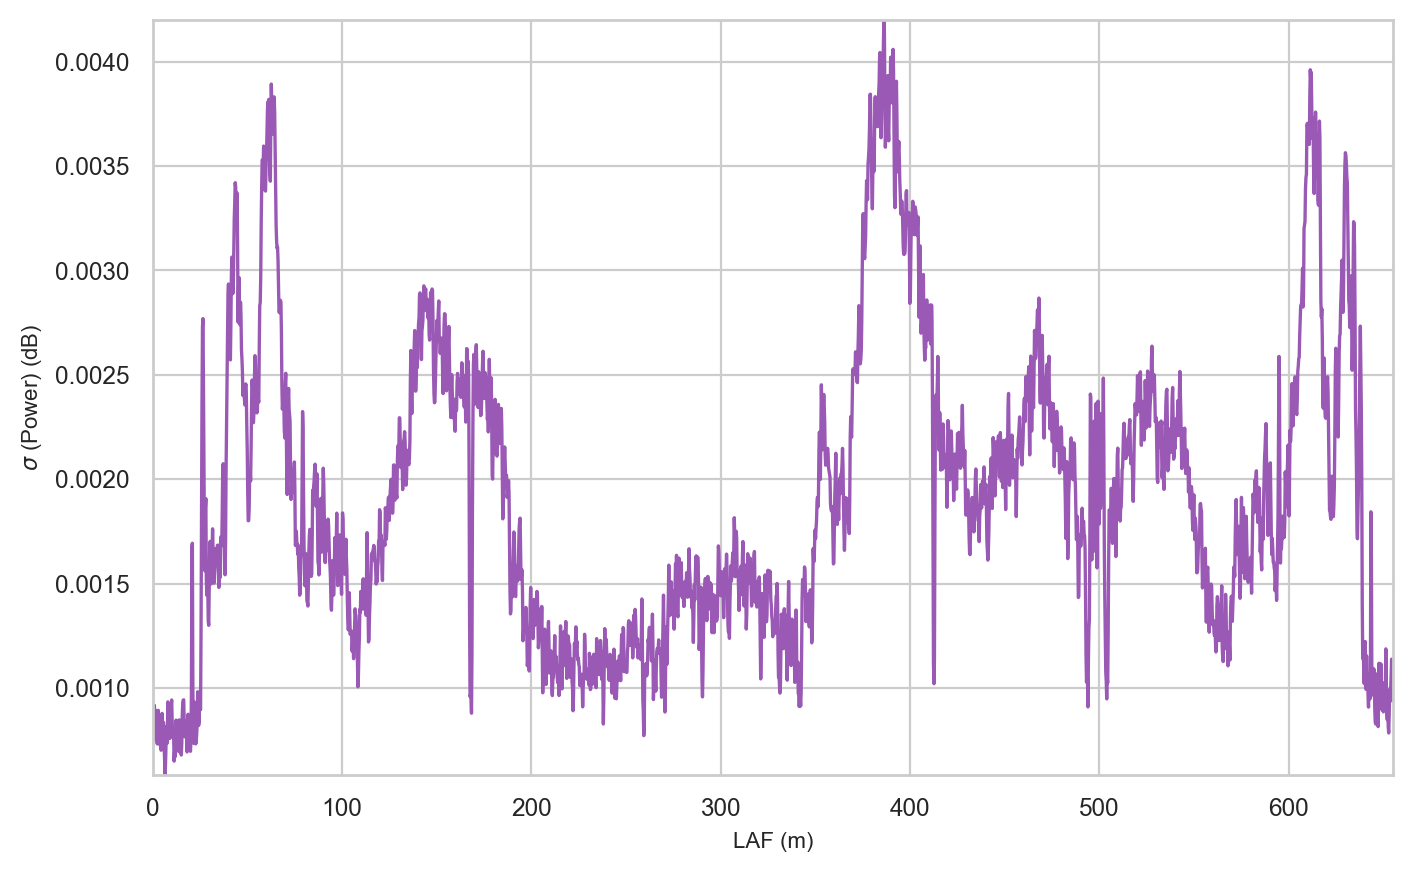

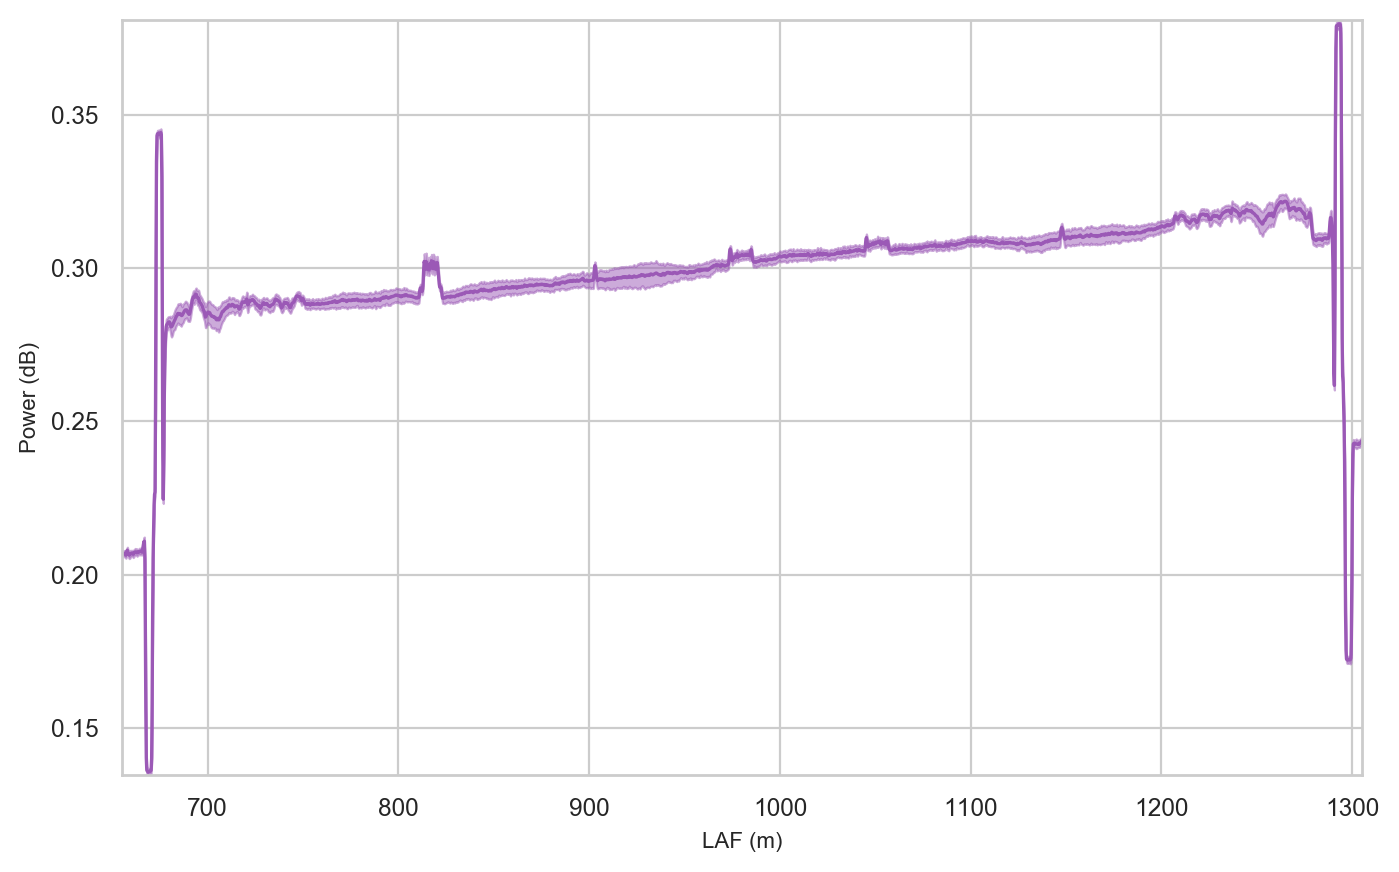

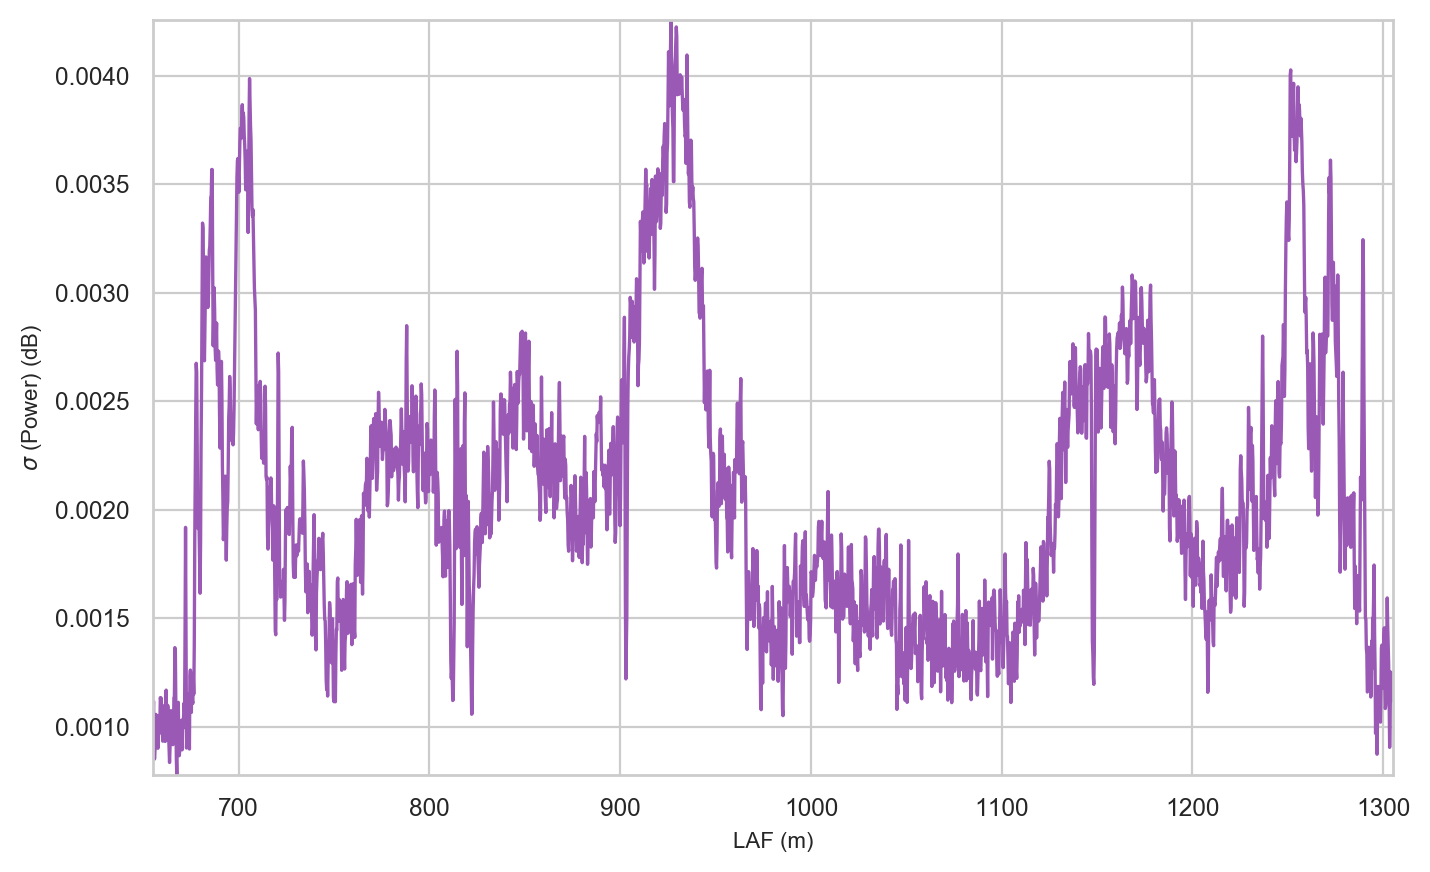

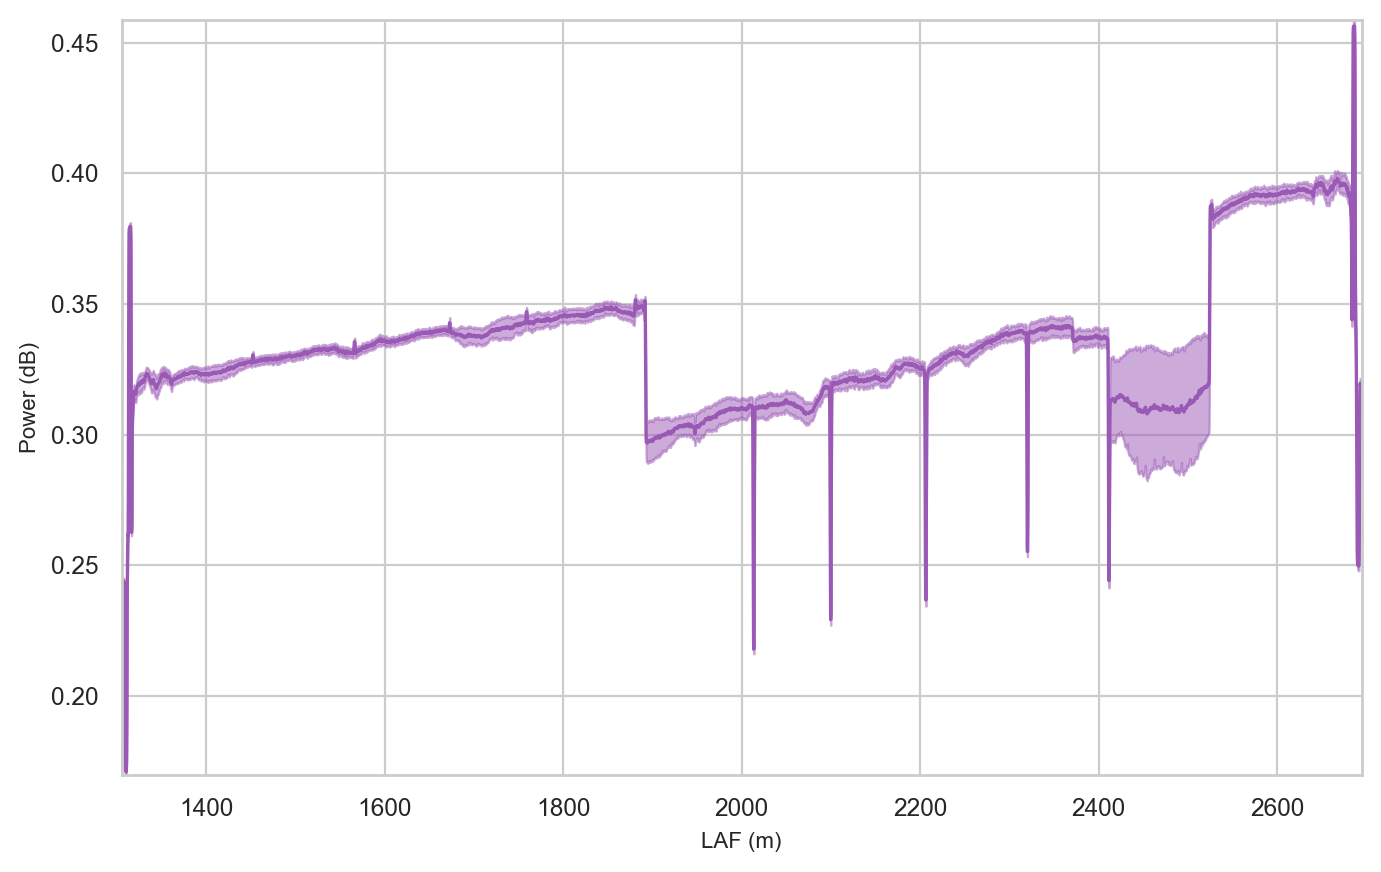

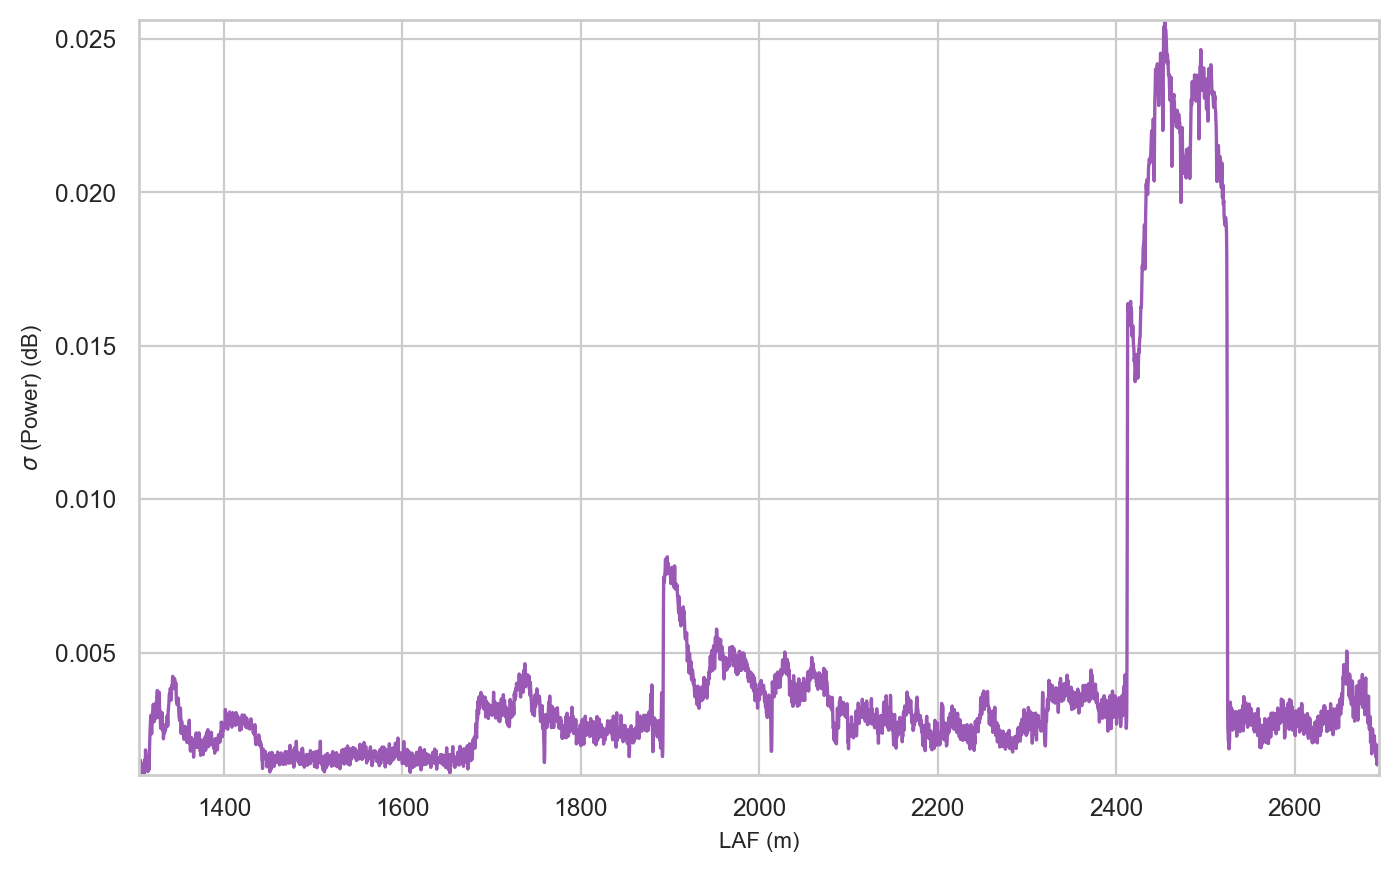

In [9]:
for c in cores:
    # Select just the given core
    c_LAF_start = core_locs[c]['LAF'][0]
    c_LAF_end = core_locs[c]['LAF'][1]    
    smpl_data = ds.sel(LAF=slice(c_LAF_start, c_LAF_end))

    # Calculate the power
    power = np.log(smpl_data.Ps / smpl_data.Pas).sel(LAF=slice(0, smpl_data.LAF.max()))
    power_timeavg = power.mean(dim='time')
    power_timestd = power.std(dim='time')

    # Entire fiber mean power with shaded uncertainty range
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(power.LAF, power_timeavg.values)
    ax.fill_between(power.LAF,
                    power_timeavg.values - power_timestd.values,
                    power_timeavg.values + power_timestd,
                    color=flatui[0], alpha=0.5)
    ax.autoscale(axis='y', tight=True)
    ax.set_xlim(c_LAF_start, c_LAF_end)

    ax.set_ylabel('Power (dB)')
    ax.set_xlabel('LAF (m)')

    # Entire fiber time-averaged standard deviation of power
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(power.LAF, power_timestd.values)

    ax.set_ylabel(r'$\sigma$ (Power) (dB)')
    ax.set_xlabel('LAF (m)')
    ax.autoscale(axis='y', tight=True)
    ax.set_xlim(c_LAF_start, c_LAF_end)


The large changes in the power's standard deviation highlight regions of fast changing temperature and artifacts, such as from where the fiber contacts the holders.

# Fiber status

## Spatial deviation in $log(\frac{P_s}{P_{as}})$

This quantity can highlight step-losses from breaks and other parts of the fiber that are behaving poorly. To do this we use the spatial standard deviation, which we here define as the standard deviation across ten spatial observations, in $P_s$ and $P_{as}$. Hausner 2016 states this is a good method for finding step losses. The stokes scattering is less senstive to temperature changes than the anti-stokes scattering. We use this behavior to find locations where the stokes scattering has more variability than the anti-stokes scattering, which may indicate a step loss.


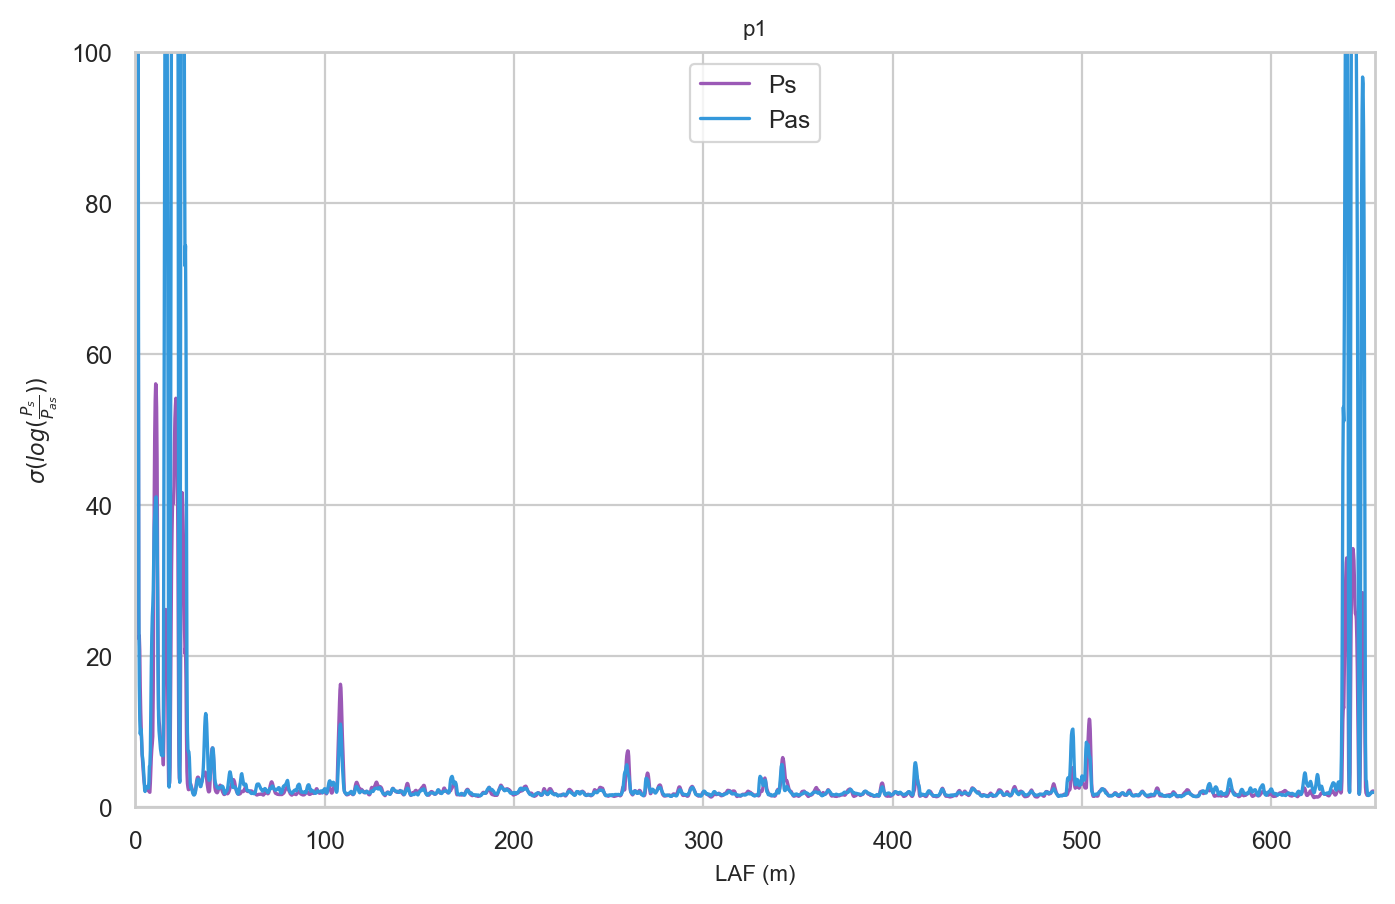

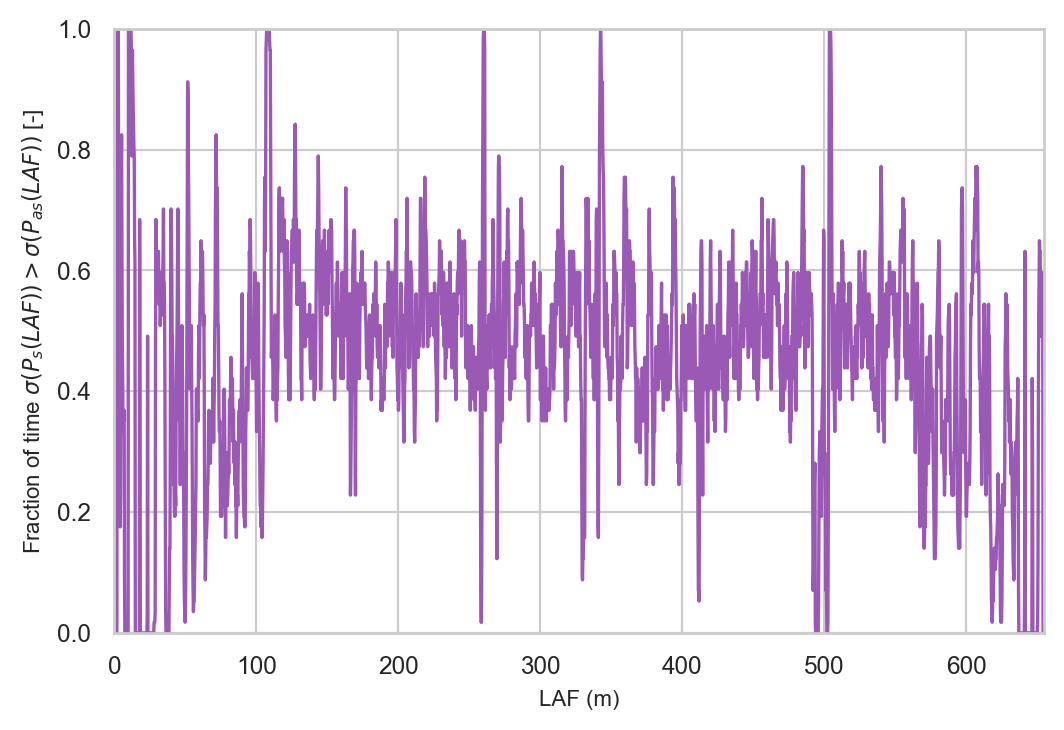

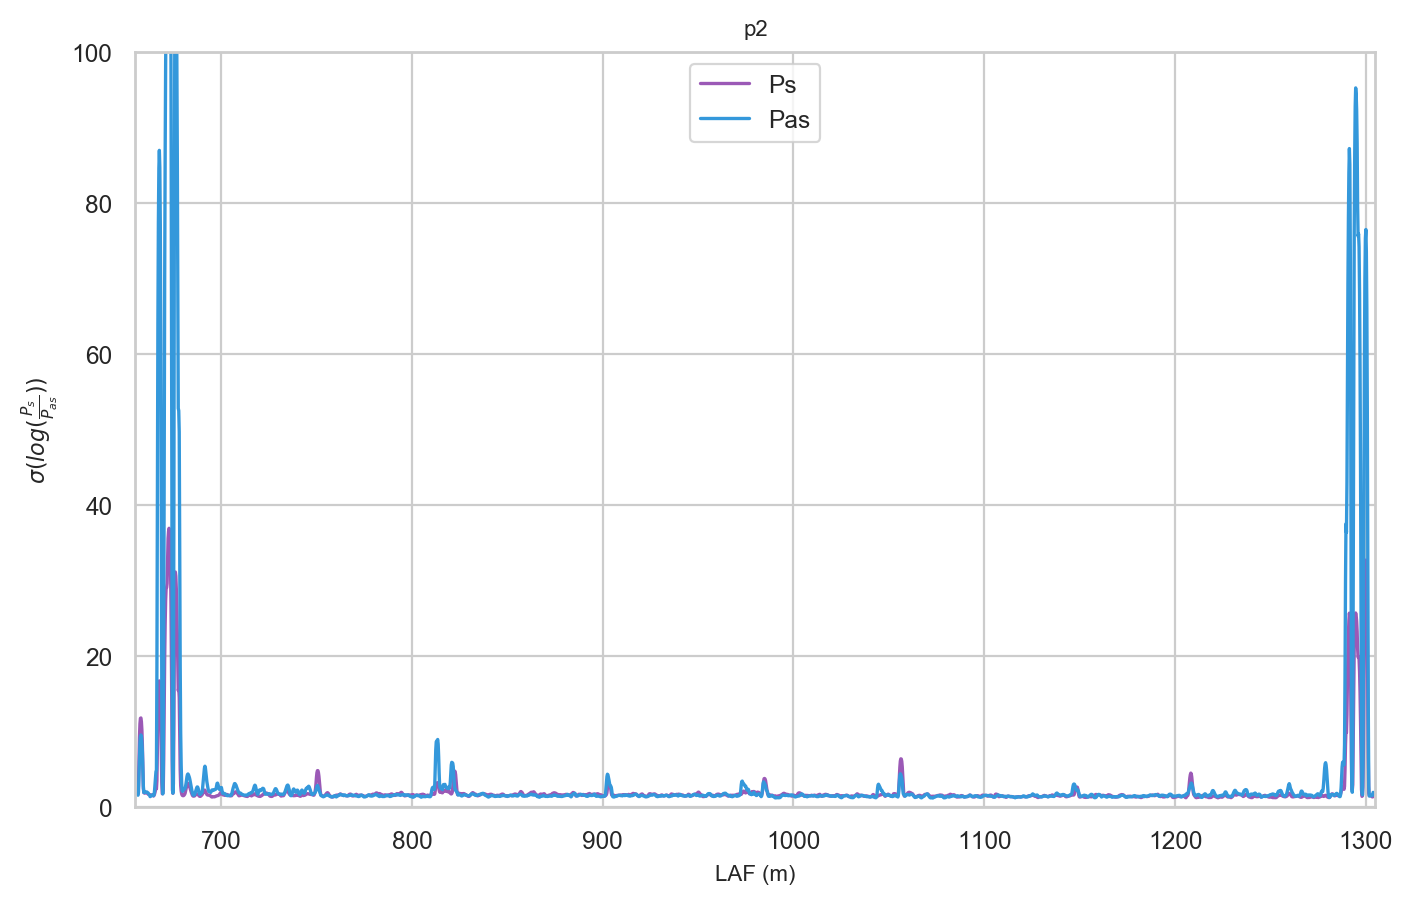

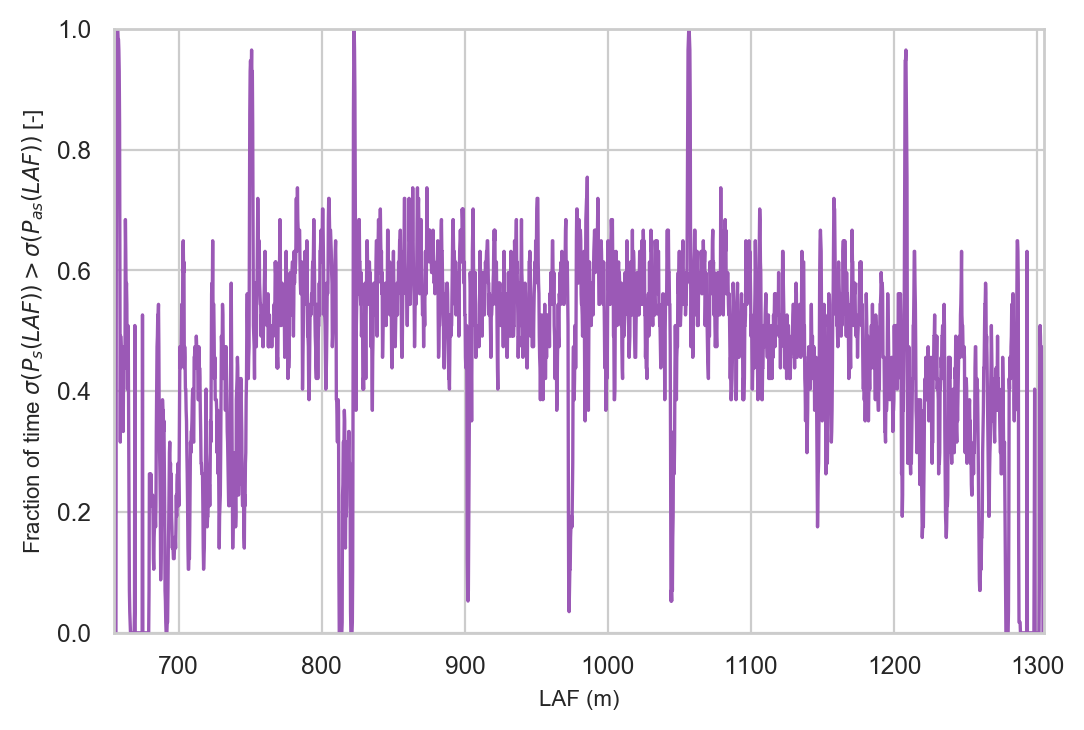

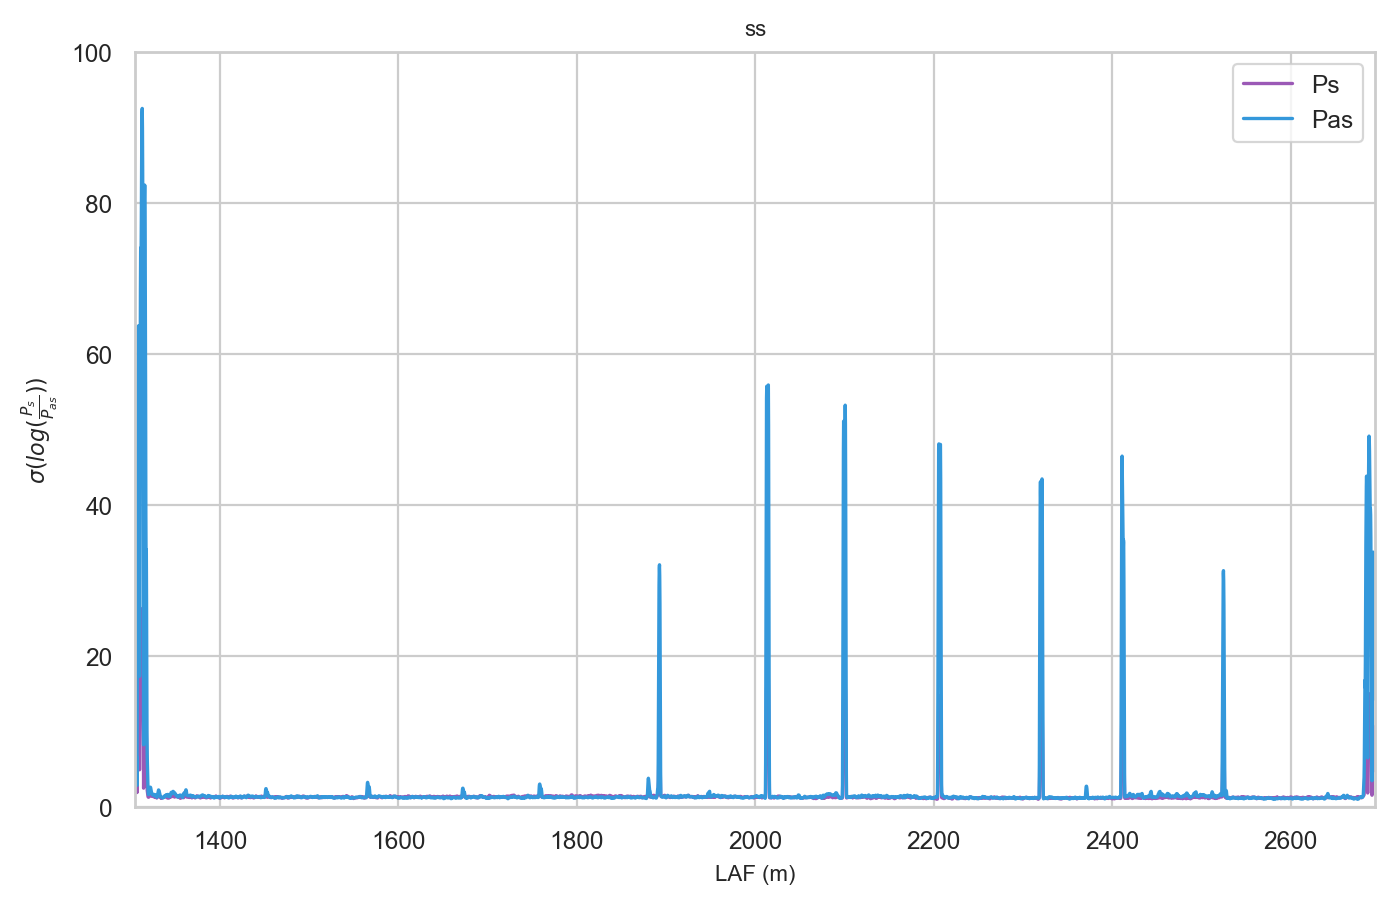

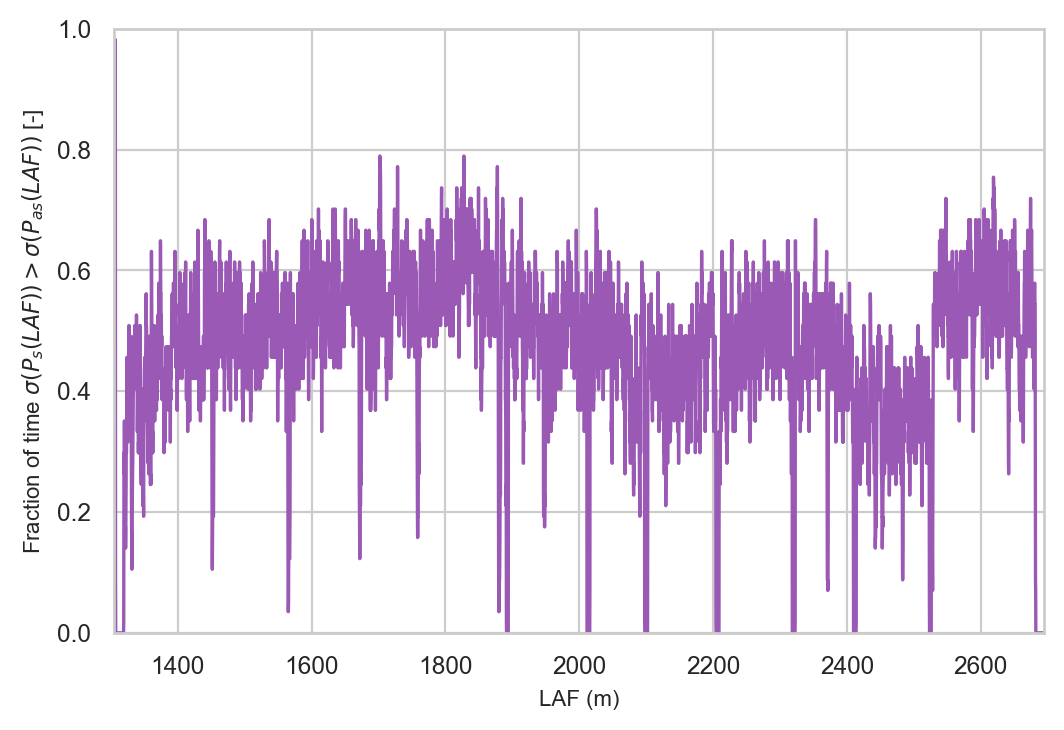

In [10]:
for c in cores:
    # Select just the given core
    c_LAF_start = core_locs[c]['LAF'][0]
    c_LAF_end = core_locs[c]['LAF'][1]    
    smpl_data = ds.sel(LAF=slice(c_LAF_start, c_LAF_end))
    
    # Spatial variance in the stokes/anti-stokes ratio
    rolling_Ps = smpl_data['Ps'].rolling(LAF=10, center=True).std()
    rolling_Pas = smpl_data['Pas'].rolling(LAF=10, center=True).std()

    # The fraction of time that the stokes variance > the anti-stokes variance.
    bad_ratio = (rolling_Ps > rolling_Pas).mean(dim='time')

    # Take the mean of the variance for plotting.
    rolling_Ps = rolling_Ps.mean(dim='time')
    rolling_Pas = rolling_Pas.mean(dim='time')

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(rolling_Ps.LAF, rolling_Ps, label='Ps')
    ax.plot(rolling_Pas.LAF, rolling_Pas, label='Pas')
    ax.legend()
    ax.set_title(c)
    ax.set_ylim(0, 100)
    ax.set_xlim(c_LAF_start, c_LAF_end)
    ax.set_ylabel(r'$\sigma (log(\frac{P_s}{P_{as}}))$')
    ax.set_xlabel('LAF (m)')
    
    
    fig, ax = plt.subplots(1, 1)
    ax.plot(bad_ratio.LAF, bad_ratio.values)
    ax.set_xlim(c_LAF_start, c_LAF_end)
    ax.set_ylim(0, 1)
    ax.set_ylabel(r'Fraction of time $\sigma(P_s(LAF)) > \sigma(P_{as}(LAF))$ [-]')
    ax.set_xlabel('LAF (m)')

Since we know there were no splices along this fiber, the locations where the mean $\sigma(P_s) > \sigma(P_{as})$ are related to other fiber artifacts, for instance locations at which the fiber bends too tightly.

This is an particularly bad looking plot. In other cases of using this method the ratio is always below 0.4 except for locations with strong mechanical bend.

The peaks line up with the locations where the fiber was wrapped around the fiber holder, indicating the possibility of mechanical strain interfereing with the fiber optic signal.